In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv("Apples_stock price dataset.csv")
df.head()

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
0,01-01-2010 00:00,102.48,7984.16,2994.24,4.59,6.84,1.18,0.10
1,01-01-2010 01:00,99.35,7995.71,2995.83,2.63,5.85,1.92,-0.24
2,01-01-2010 02:00,103.32,8000.89,2998.12,2.62,6.24,2.44,-0.83
3,01-01-2010 03:00,107.73,7995.76,3004.53,3.12,6.40,2.37,0.06
4,01-01-2010 04:00,98.98,8002.45,2997.15,4.27,4.94,1.93,-0.22


In [3]:
df.isnull().sum()

timestamp             0
stock_price          31
nasdaq_index          7
sp500_index           4
inflation_rate        8
unemployment_rate     4
interest_rate         2
market_sentiment      4
dtype: int64

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

In [5]:
print(df['timestamp'].tail())

99995   2021-05-29 11:00:00
99996   2021-05-29 12:00:00
99997   2021-05-29 13:00:00
99998   2021-05-29 14:00:00
99999   2021-05-29 15:00:00
Name: timestamp, dtype: datetime64[ns]


In [6]:
df['stock_price'] = df['stock_price'].ffill()

In [7]:
col_fill = [
    'nasdaq_index',
    'sp500_index',
    'inflation_rate',
    'unemployment_rate',
    'interest_rate',
    'market_sentiment']

for col in col_fill:
    df[col] = df[col].fillna(df[col].median())

In [8]:
df.isnull().sum()

timestamp            0
stock_price          0
nasdaq_index         0
sp500_index          0
inflation_rate       0
unemployment_rate    0
interest_rate        0
market_sentiment     0
dtype: int64

In [9]:
df.describe()

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
count,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,2015-09-15 07:30:00,299.984698,259114.534761,101463.063479,3.004250,4.99599,2.001476,0.003208
min,2010-01-01 00:00:00,9.540000,7984.160000,2981.780000,1.000000,3.00000,0.500000,-1.000000
25%,2012-11-07 15:45:00,248.605000,134729.690000,51575.350000,2.010000,4.00000,1.250000,-0.500000
50%,2015-09-15 07:30:00,300.070000,257861.010000,100923.145000,3.010000,4.99000,2.000000,0.000000
75%,2018-07-22 23:15:00,351.440000,385204.717500,151634.497500,4.000000,5.99000,2.750000,0.500000
max,2021-05-29 15:00:00,601.660000,507957.790000,200815.810000,5.000000,7.00000,3.500000,1.000000
std,NaN,91.448911,144509.314033,57293.368074,1.152747,1.15467,0.864926,0.578062


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          100000 non-null  datetime64[ns]
 1   stock_price        100000 non-null  float64       
 2   nasdaq_index       100000 non-null  float64       
 3   sp500_index        100000 non-null  float64       
 4   inflation_rate     100000 non-null  float64       
 5   unemployment_rate  100000 non-null  float64       
 6   interest_rate      100000 non-null  float64       
 7   market_sentiment   100000 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 6.1 MB


In [11]:
df.tail()

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
99995,2021-05-29 11:00:00,498.72,507952.14,200804.70,3.82,3.62,3.32,-0.16
99996,2021-05-29 12:00:00,497.04,507943.81,200807.80,1.75,4.90,2.72,0.17
99997,2021-05-29 13:00:00,501.97,507932.52,200809.97,2.42,4.99,1.68,-0.48
99998,2021-05-29 14:00:00,498.91,507942.05,200807.35,2.79,5.86,1.08,0.40
99999,2021-05-29 15:00:00,500.60,507948.54,200815.81,3.60,3.13,2.77,-0.23


In [12]:
for col in ['stock_price', 'nasdaq_index', 'sp500_index', 'inflation_rate', 'unemployment_rate', 'interest_rate', 'market_sentiment']:
    df[col] = winsorize(df[col], limits=[0.05, 0.05])

def replace_outliers(df, column):
    mean = df[column].mean()
    std = df[column].std()
    upper_bound = mean + 3 * std
    lower_bound = mean - 3 * std
    df[column] = np.where(df[column] > upper_bound, mean, df[column])
    df[column] = np.where(df[column] < lower_bound, mean, df[column])
    return df


outlier_col = ['stock_price', 'nasdaq_index', 'sp500_index']

for col in outlier_col:
    df = replace_outliers(df, col)

# Verify the changes
df.describe()

C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\numpy\lib\function_base

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
count,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2015-09-15 07:30:00,299.980598,259130.040440,101460.017775,3.004091,4.996325,2.001528,0.003180
min,2010-01-01 00:00:00,134.110000,33594.140000,12932.260000,1.200000,3.200000,0.650000,-0.900000
25%,2012-11-07 15:45:00,248.605000,134729.690000,51575.350000,2.010000,4.000000,1.250000,-0.500000
50%,2015-09-15 07:30:00,300.070000,257861.010000,100923.145000,3.010000,4.990000,2.000000,0.000000
75%,2018-07-22 23:15:00,351.440000,385204.717500,151634.497500,4.000000,5.990000,2.750000,0.500000
max,2021-05-29 15:00:00,465.680000,483152.470000,190797.200000,4.800000,6.810000,3.350000,0.900000
std,NaN,87.995423,142458.814345,56475.239748,1.136534,1.138772,0.852858,0.569876


In [13]:
for col in ['stock_price', 'nasdaq_index', 'sp500_index', 'inflation_rate', 'unemployment_rate', 'interest_rate', 'market_sentiment']:
    df = replace_outliers(df, col)

In [14]:
df = df[df['timestamp'].dt.hour >= 4]

In [15]:
df = df[df['timestamp'].dt.hour < 20]

In [16]:
df = df[df['timestamp'].dt.dayofweek < 5]

In [17]:
df

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
4,2010-01-01 04:00:00,134.11,33594.14,12932.26,4.27,4.94,1.93,-0.22
5,2010-01-01 05:00:00,134.11,33594.14,12932.26,2.32,4.10,1.66,-0.83
6,2010-01-01 06:00:00,134.11,33594.14,12932.26,2.63,5.45,3.00,-0.81
7,2010-01-01 07:00:00,134.11,33594.14,12932.26,4.06,3.38,3.28,0.00
8,2010-01-01 08:00:00,134.11,33594.14,12932.26,2.10,4.82,1.76,-0.63
...,...,...,...,...,...,...,...,...
99975,2021-05-28 15:00:00,465.68,483152.47,190797.20,4.80,4.60,2.59,0.35
99976,2021-05-28 16:00:00,465.68,483152.47,190797.20,3.11,3.83,2.44,-0.63
99977,2021-05-28 17:00:00,465.68,483152.47,190797.20,3.79,6.57,0.66,-0.01
99978,2021-05-28 18:00:00,465.68,483152.47,190797.20,2.39,6.59,2.52,0.21


**Visualisation**

BOX PLOT

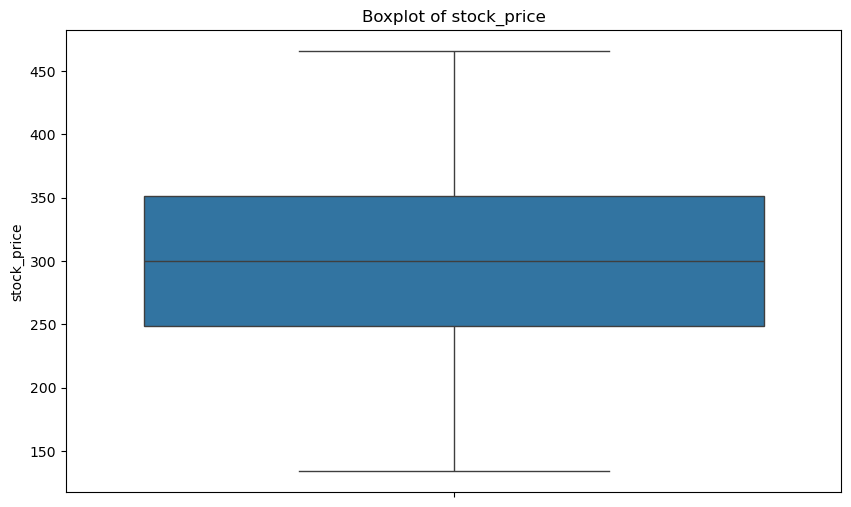

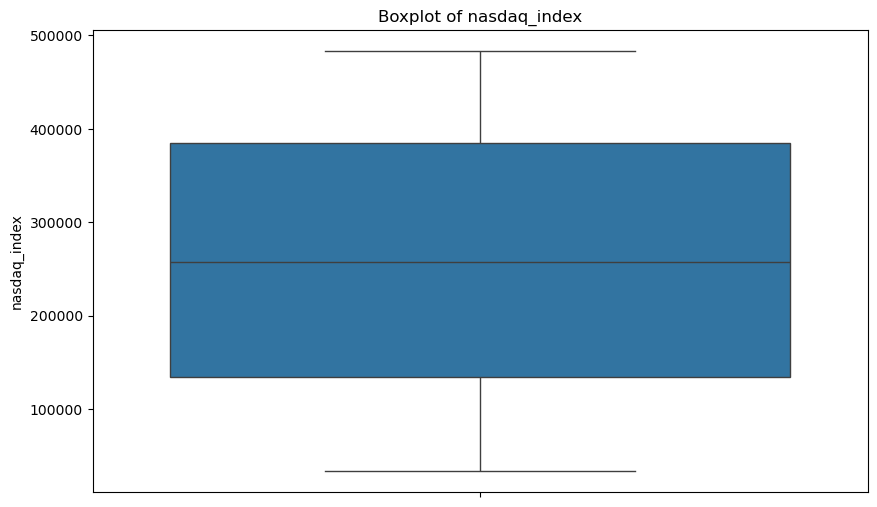

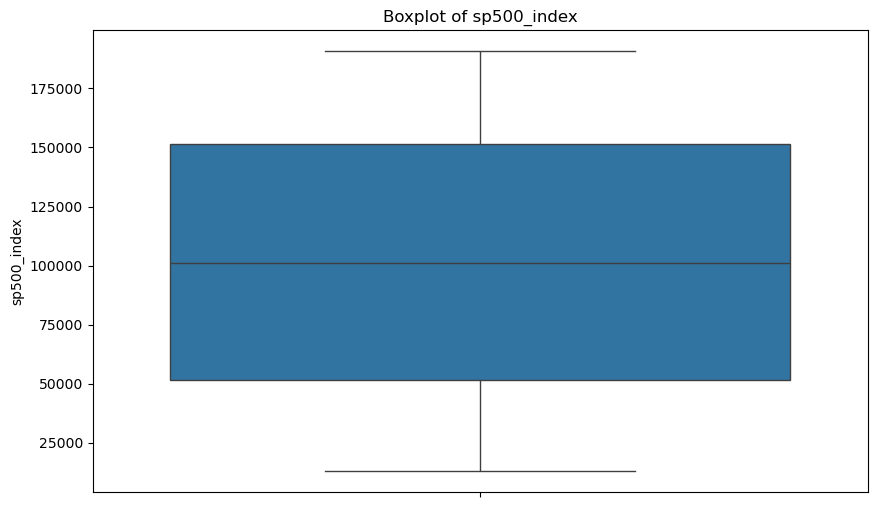

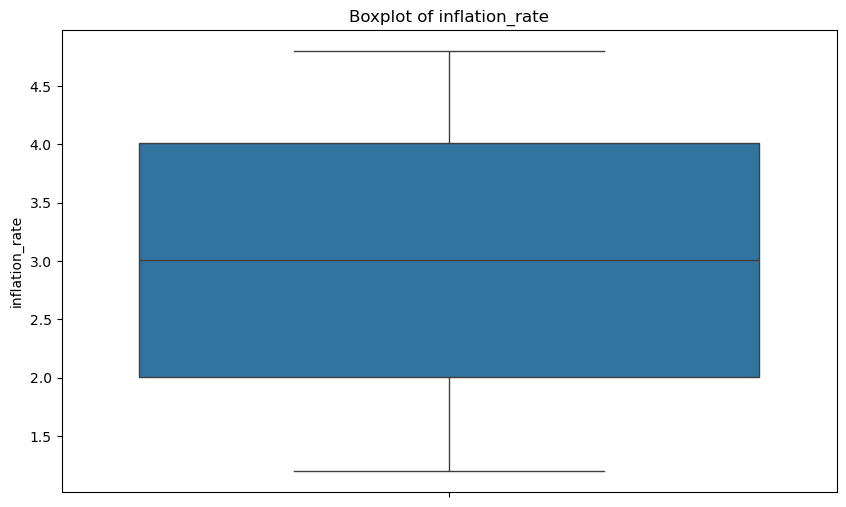

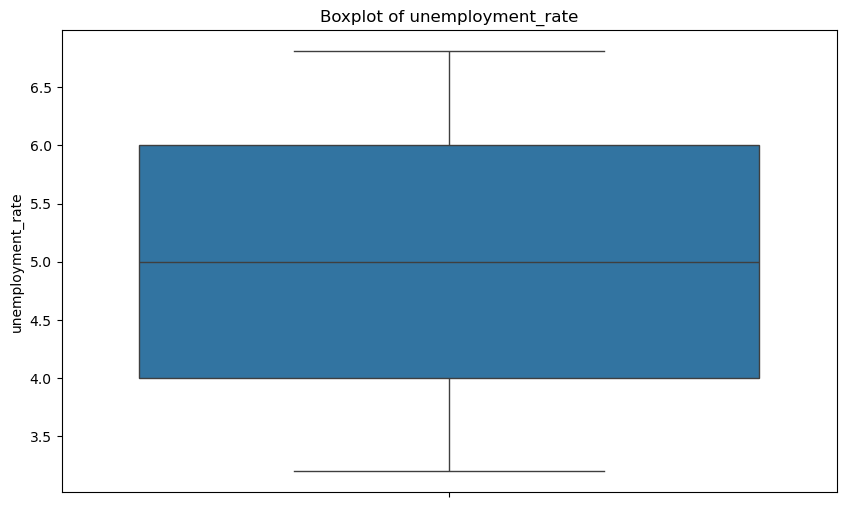

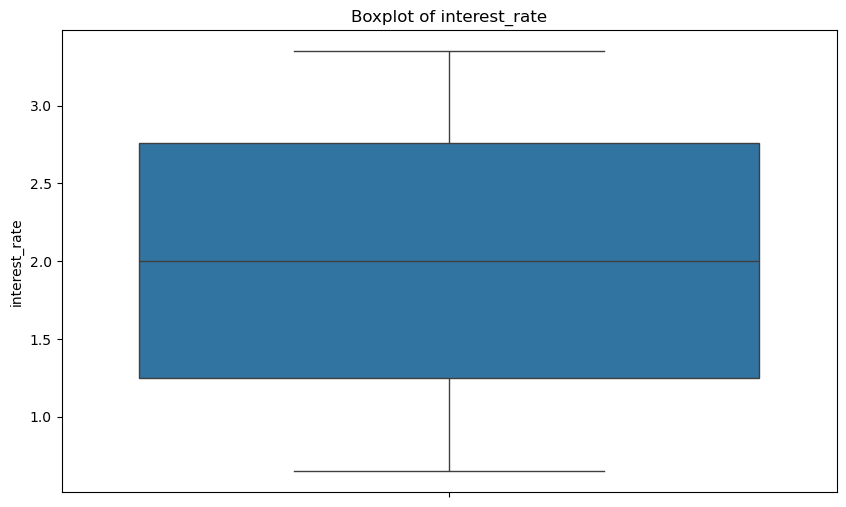

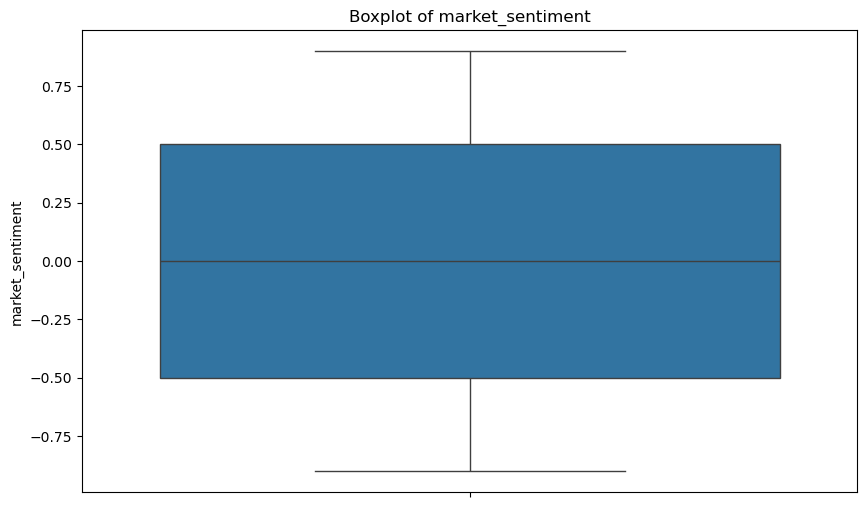

In [18]:
for col in ['stock_price', 'nasdaq_index', 'sp500_index', 'inflation_rate', 'unemployment_rate', 'interest_rate', 'market_sentiment']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df[col])  # Use 'col' here
    plt.title(f"Boxplot of {col}")  # Use 'col' here
    plt.show()

HISTOGRAM



array([[<Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'stock_price'}>,
        <Axes: title={'center': 'nasdaq_index'}>],
       [<Axes: title={'center': 'sp500_index'}>,
        <Axes: title={'center': 'inflation_rate'}>,
        <Axes: title={'center': 'unemployment_rate'}>],
       [<Axes: title={'center': 'interest_rate'}>,
        <Axes: title={'center': 'market_sentiment'}>, <Axes: >]],
      dtype=object)

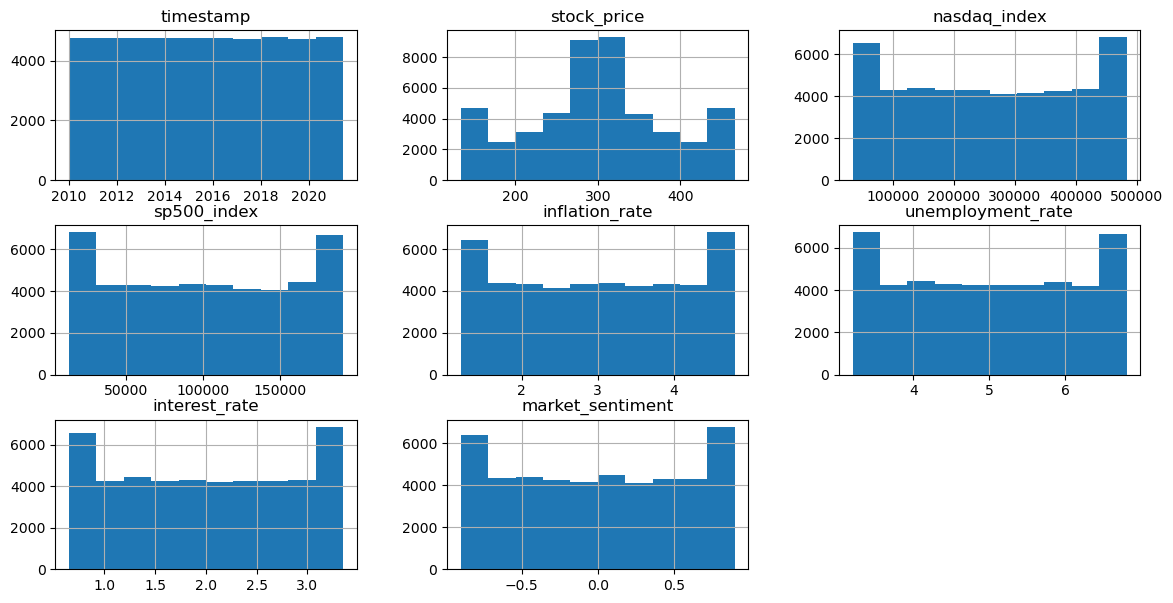

In [19]:
df.hist(figsize=(14, 7))

LINE PLOT

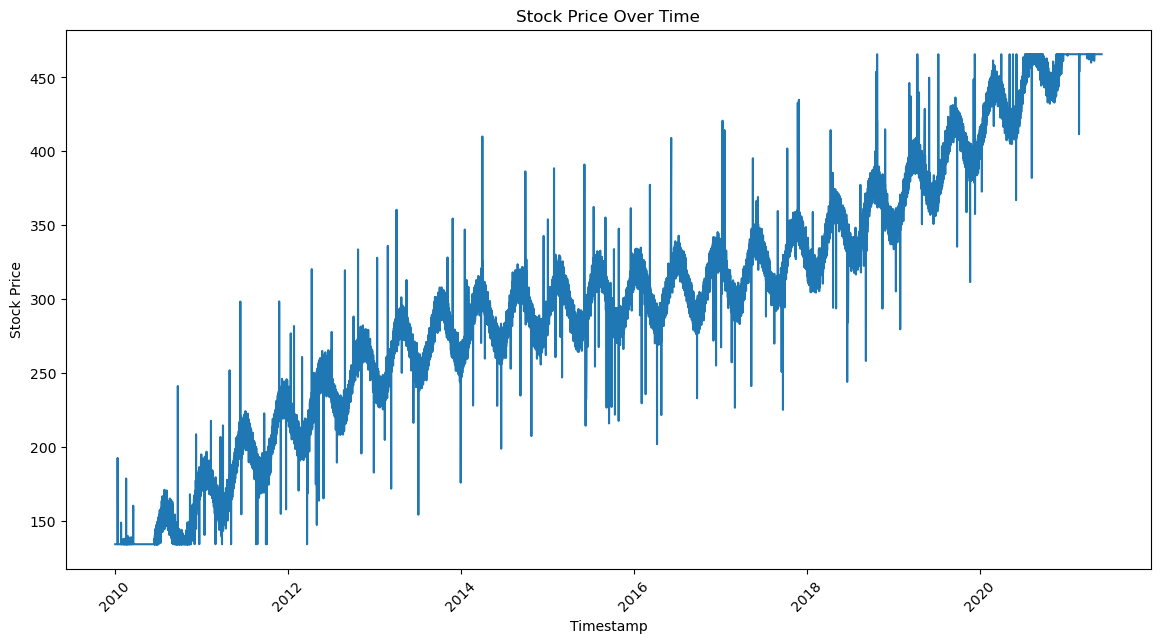

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting stock price over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='timestamp', y='stock_price', data=df)
plt.title('Stock Price Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.show()


Stock Price vs. NASDAQ Index

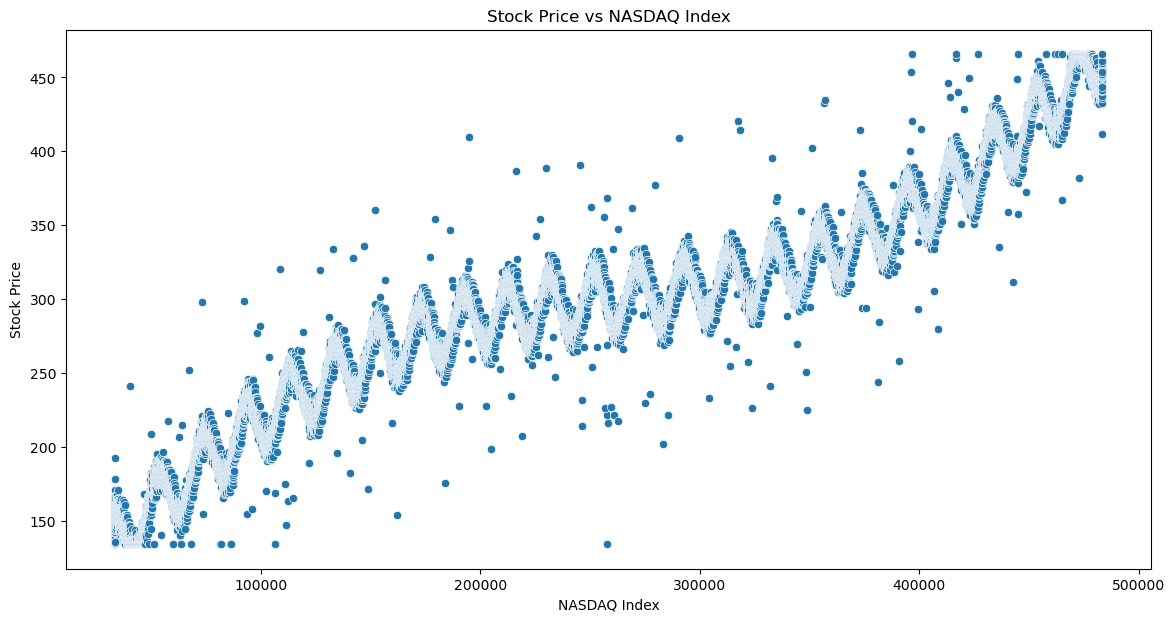

In [21]:
# Scatter plot of stock price vs NASDAQ index
plt.figure(figsize=(14, 7))
sns.scatterplot(x='nasdaq_index', y='stock_price', data=df)
plt.title('Stock Price vs NASDAQ Index')
plt.xlabel('NASDAQ Index')
plt.ylabel('Stock Price')
plt.show()


Stock price VS Sp500 Index

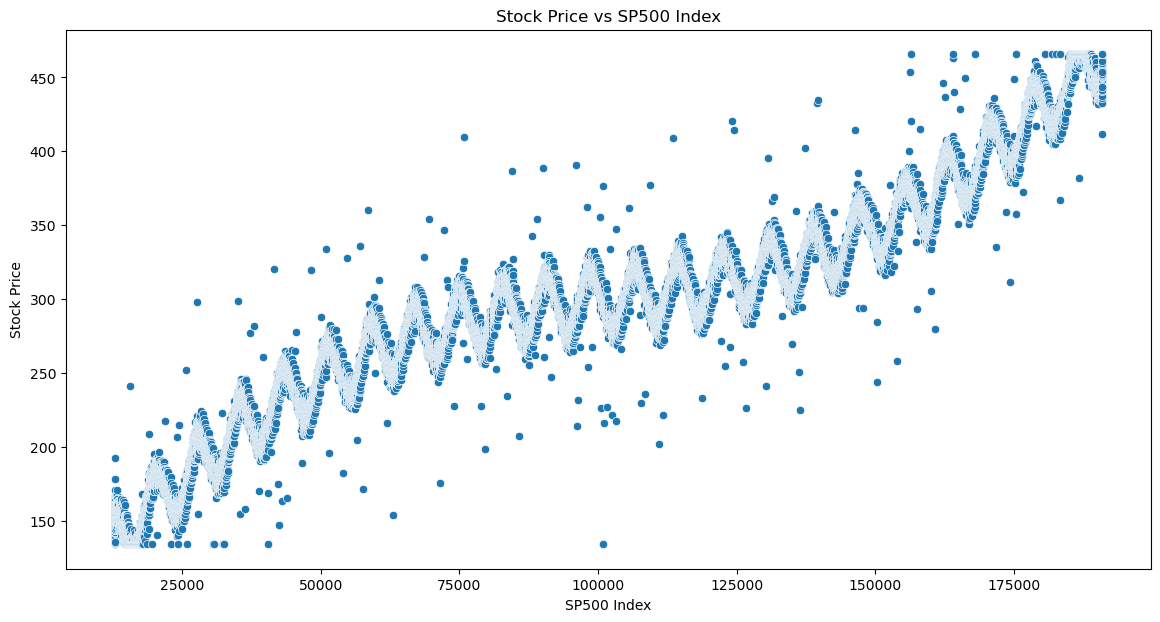

In [22]:
# Scatter plot of stock price vs SP500 index
plt.figure(figsize=(14, 7))
sns.scatterplot(x='sp500_index', y='stock_price', data=df)
plt.title('Stock Price vs SP500 Index')
plt.xlabel('SP500 Index')
plt.ylabel('Stock Price')
plt.show()


3D Scatter Plot

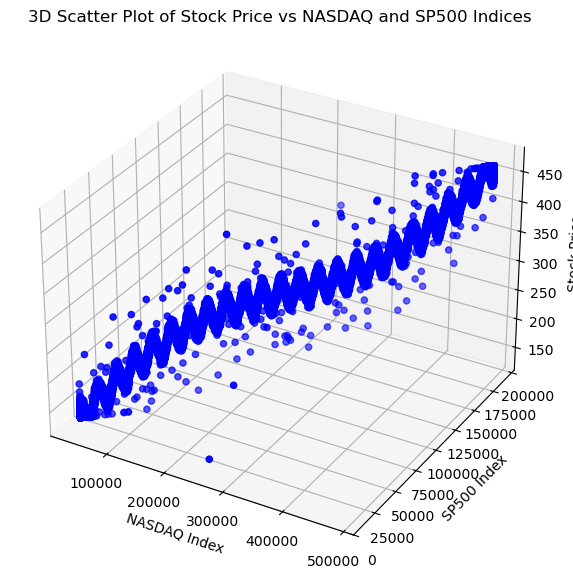

In [23]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['nasdaq_index'], df['sp500_index'], df['stock_price'], c='b', marker='o')
ax.set_xlabel('NASDAQ Index')
ax.set_ylabel('SP500 Index')
ax.set_zlabel('Stock Price')
plt.title('3D Scatter Plot of Stock Price vs NASDAQ and SP500 Indices')
plt.show()


Stock Price Distribution

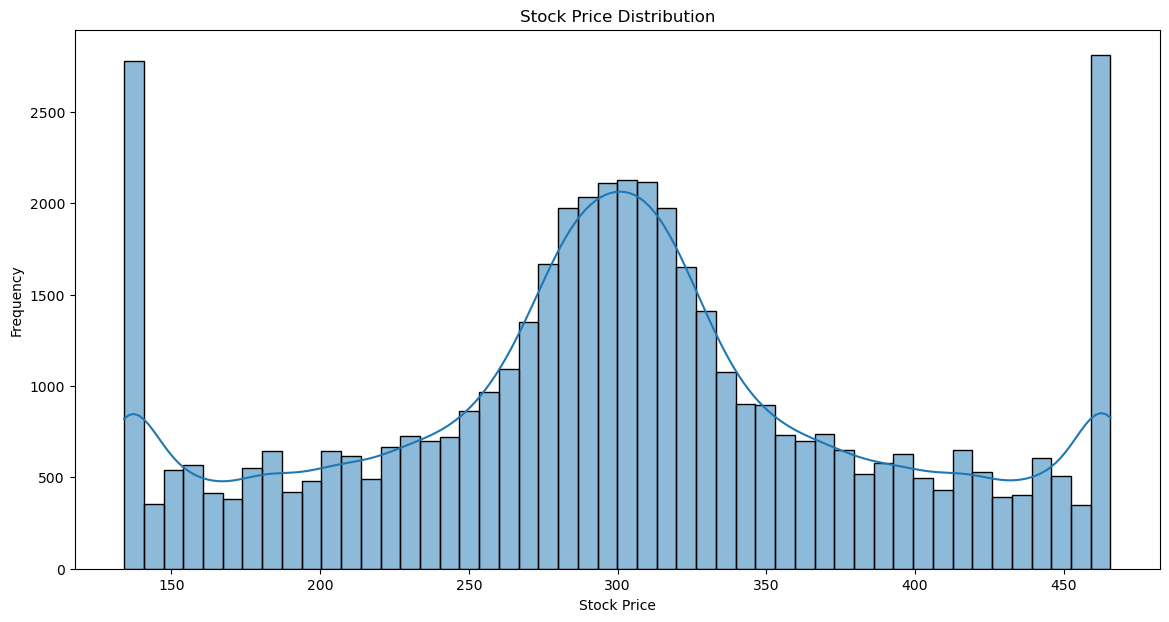

In [24]:
# Histogram of stock price distribution
plt.figure(figsize=(14, 7))
sns.histplot(df['stock_price'], bins=50, kde=True)
plt.title('Stock Price Distribution')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.show()


Correlation Heatmap

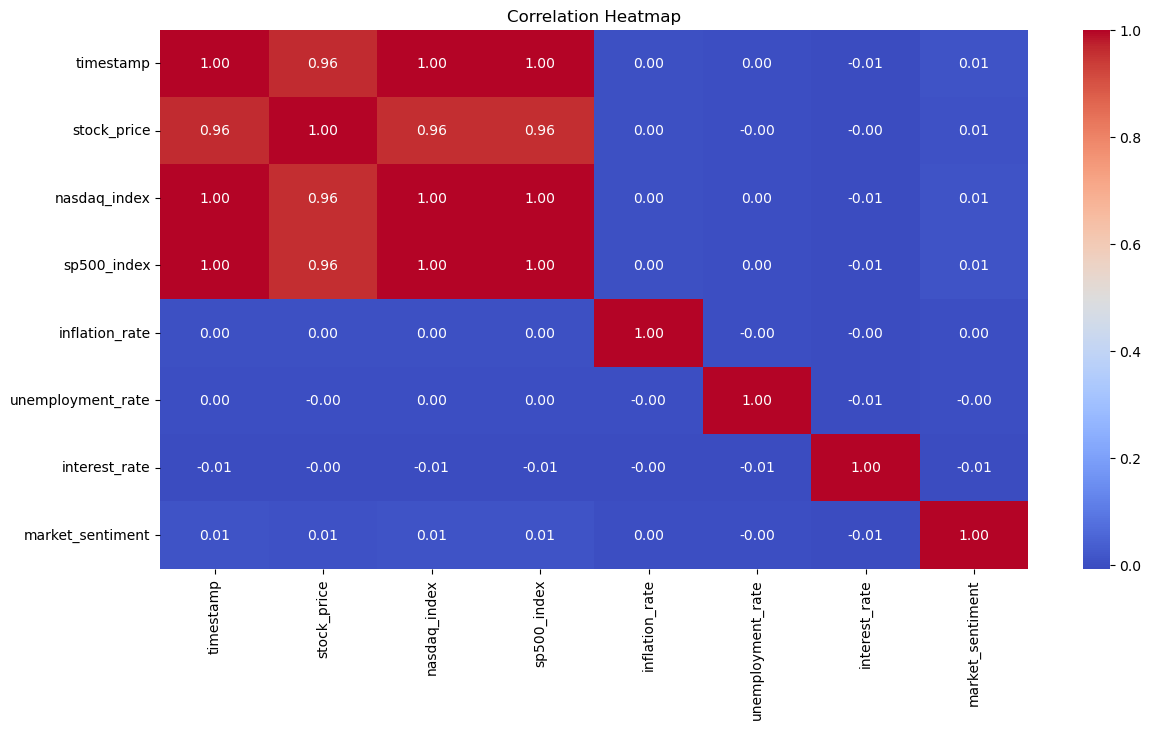

In [25]:
# Correlation heatmap
plt.figure(figsize=(14, 7))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


Time Series Decomposition



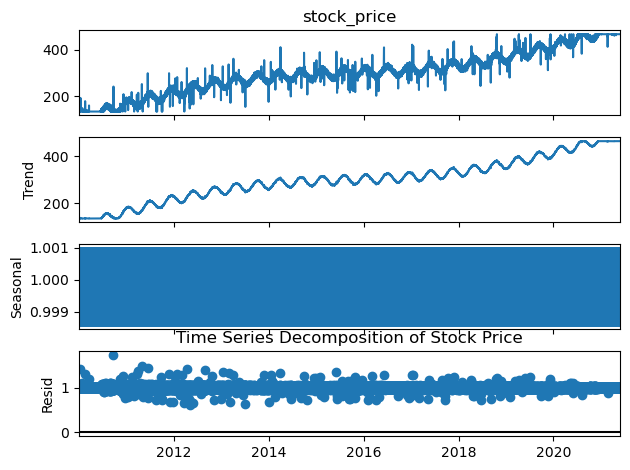

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df.set_index('timestamp')['stock_price'], model='multiplicative', period=24)
result.plot()
plt.title('Time Series Decomposition of Stock Price')
plt.show()
